# Выбор локации для скважины

Для нефтедобывающей компании «ГлавРосГосНефть» нам необходимо определить регион, в котором разработка месторождений нефти принесет бо́льшую прибыль. 

Нам предоставлены пробы нефти в трех регионах. Обучим модель линейной регрессии, которая сможет прогнозировать по имеющимся характеристикам объем запасов в конкретной скважине. Далее нам необходимо написать функцию, которая позволит выбрать 200 самых богатых по запасам скважин из представленных в выборке и посчитает прибыль. Объём запасов в скважине указан в тыс. баррелей.

В конце с помощью техники Bootstrap мы проанализируем возможную прибыль и риски. Все расчеты будем производить на заранее выделенной валидационной выборке.



**Данные:**

Данные предоставлены в трех файлах. Каждый файл для каждого региона.


**Признаки:**

- `'f0'`, `'f1'`, `'f2'` - технические показатели пробы нефти одной конкретной скважины в регионе;
- `'product'` - объем запасов в этой скважине в тысячах баррелей.

**Заказчику важно**:

- оцениваем качество с помощью RMSE
- расчет рисков и прибыли для каждого региона
- использовать модель линейной регрессии


**План работы**:

[1. Загрузка и подготовка данных](#section0.1)<br/>
[2. Обучение и проверка модели](#section0.2)<br/>
[3. Подготовка к расчёту прибыли](#section0.3)<br/>
[4. Расчёт прибыли и рисков](#section0.4)<br/>
[5. Общий вывод по работе](#section0.5)<br/>

## Загрузка и подготовка данных<a id='section0.1'></a>

In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# если можно, открываем файл из локального носителя
# или с Jupyter Hub
try:
    df_geo_0 = pd.read_csv('geo_data_0.csv')
    df_geo_1 = pd.read_csv('geo_data_1.csv')
    df_geo_2 = pd.read_csv('geo_data_2.csv')
except:
    df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

Далее ознакомимся с данными в нашей таблице.

In [3]:
regions = [df_geo_0, df_geo_1, df_geo_2]
for region in regions:
    print(region.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

Пропущенных значений в наших данных нет, названия колонок в норме. Тип данных также соответствует значениям.

В следующей ячейке напишем функцию, которая уберет выбросы из данных, а также разделит выборку на тренировочную и валидационную.

In [4]:
def return_sample(data):
    
    '''Функция возвращает тренировочные и 
    валидационные подвыборки, готовые для передачи в модель'''
    
    global features_train, features_valid, target_train, target_valid
    
    features_df_total = data[['f0','f1','f2']]
    target_df_total = data[['product']]
    features_train, features_valid, target_train, target_valid = train_test_split(
        features_df_total, target_df_total, test_size=0.25, random_state=42)
    
    q_25 = np.quantile(features_train['f0'], 0.25)
    q_75 = np.quantile(features_train['f0'], 0.75)
    f0_x_max = q_75 + (q_75 - q_25) * 1.5
    f0_x_min = q_25 - (q_75 - q_25) * 1.5
    
    q_25 = np.quantile(features_train['f1'], 0.25)
    q_75 = np.quantile(features_train['f1'], 0.75)
    f1_x_max = q_75 + (q_75 - q_25) * 1.5
    f1_x_min = q_25 - (q_75 - q_25) * 1.5
    
    q_25 = np.quantile(features_train['f2'], 0.25)
    q_75 = np.quantile(features_train['f2'], 0.75)
    f2_x_max = q_75 + (q_75 - q_25) * 1.5
    f2_x_min = q_25 - (q_75 - q_25) * 1.5
    
    # Очищаем тренировочные данные от выбросов
    features_train = features_train.query('(@f0_x_max > f0 > @f0_x_min)and(@f1_x_max > f1 > @f1_x_min)and(@f2_x_max > f2 > @f2_x_min)')
    indexes = features_train.index
    target_train = pd.DataFrame(target_train['product'][indexes]).reset_index(drop=True)
    features_train = features_train.reset_index(drop=True)    
    return features_train, features_valid, target_train, target_valid

**Промежуточный вывод:**

На этом шаге мы загрузили данные, написали функцию для удаления выбросов и разбиения данных на подвыборки. Ее будем применять далее. Здесь также следует отметить, что мною была проведена попытка стандартизировать наши данные, но, обучив модель на стандартизированных и исходных данных, сравнение их результатов значимой разницы не дало. Решил оставить данные в исходном виде.

## Обучение и проверка модели<a id='section0.2'></a>

В условиях задания сказано, что лучше всего с нашими данными справляется модель линейной регрессии. Далее обучим модели для каждого региона с помощью ранее созданной функции.

Для упрощения вывода результатов напишем еще одну функцию:

In [5]:
def print_info(model_lr, features_train, features_valid, target_train, target_valid):
    
    '''Функция выводит на печать информацию о качестве обученной модели'''

    rmse = mean_squared_error(target_valid, model_lr.predict(features_valid))**0.5
    print("RMSE = " + 
          str(rmse) + "\nПредсказанный средний запас сырья = " + 
          str(model_lr.predict(features_valid).mean()) +
          "\nФактический средний запас = " + str(target_valid['product'].mean()) + "\n"*2)
    return

In [6]:
# Обучение моделей для каждого региона
model_geo_0 = 0
model_geo_1 = 0
model_geo_2 = 0

for region in regions:
    if model_geo_0 == 0:
        features_train_geo_0, features_valid_geo_0, target_train_geo_0, target_valid_geo_0 = return_sample(region)
        model_lr = LinearRegression(n_jobs=-1)
        model_lr.fit(features_train_geo_0, target_train_geo_0)
        print("Для региона 0")
        print_info(model_lr, features_train_geo_0, features_valid_geo_0, target_train_geo_0, target_valid_geo_0)
        model_geo_0 = model_lr
    elif model_geo_1 == 0:
        features_train_geo_1, features_valid_geo_1, target_train_geo_1, target_valid_geo_1 = return_sample(region)
        model_lr = LinearRegression(n_jobs=-1)
        model_lr.fit(features_train_geo_1, target_train_geo_1)
        print("Для региона 1")
        print_info(model_lr, features_train_geo_1, features_valid_geo_1, target_train_geo_1, target_valid_geo_1)
        model_geo_1 = model_lr
    elif model_geo_2 == 0:
        features_train_geo_2, features_valid_geo_2, target_train_geo_2, target_valid_geo_2 = return_sample(region)
        model_lr = LinearRegression(n_jobs=-1)
        model_lr.fit(features_train_geo_2, target_train_geo_2)
        print("Для региона 2")
        print_info(model_lr, features_train_geo_2, features_valid_geo_2, target_train_geo_2, target_valid_geo_2)
        model_geo_2 = model_lr

Для региона 0
RMSE = 37.75662269913079
Предсказанный средний запас сырья = 92.39155529688513
Фактический средний запас = 92.32595637084387


Для региона 1
RMSE = 0.89027512358955
Предсказанный средний запас сырья = 68.7130362670957
Фактический средний запас = 68.72538074722745


Для региона 2
RMSE = 40.15029804159093
Предсказанный средний запас сырья = 94.56455982104195
Фактический средний запас = 95.15099907171961




**Промежуточный вывод:**

Лучше всего с предсказанием запасов справляется модель для региона 1: в среднем ошибка всего на 890 баррелей.

Для двух других моделей результат однозначно хуже: ошибка на 38 и 40 тыс. баррелей. При этом фактический средний запас не так сильно отличается от предсказанного.

Здесь также стоит отметить, что сначала я пробовал обучить одну общую модель на сконкатенированных данных. Результат вышел не очень. Поэтому на этом шаге обучены модели для каждого региона.

## Подготовка к расчёту прибыли<a id='section0.3'></a>

Теперь сохраним в переменных ключевые значения для расчета прибыли. А также посчитаем, какой объем нам должны дать выбранные скважины, чтобы окупить вложения (по условия задания, 10 млрд рублей).

In [7]:
# Расходы на освоение региона
DEVELOP_COSTS = 10_000_000_000

In [8]:
PRICE = 450_000
NUMBER_OF_WELLS = 200

In [9]:
# Среднее значение сырья для окупаемости одной скважины (при выборе 200 лучших, указано в тыс. баррелей)
PAYBACK_PER_WELL = DEVELOP_COSTS / (NUMBER_OF_WELLS * PRICE)
PAYBACK_PER_WELL

111.11111111111111

In [10]:
# Общий объем сырья для окупаемости 200 лучших скважин региона
TOTAL_PAYBACK = PAYBACK_PER_WELL * NUMBER_OF_WELLS
TOTAL_PAYBACK

22222.222222222223

Далее для оценки сравним средние значения сырья для окупаемости одной скважины со средними значениями запасов из исходной таблицы:

In [11]:
print(float(target_train_geo_0.mean()) - PAYBACK_PER_WELL)
print(float(target_train_geo_1.mean()) - PAYBACK_PER_WELL)
float(target_train_geo_2.mean()) - PAYBACK_PER_WELL

-18.557905520474378
-42.274534990246465


-16.353360902215712

**Промежуточный вывод:**

На этом шаге мы выяснили, что безубыточная добыча будет возможна, если выбранные нами 200 скважин в среднем будут приносить 111,12 тысяч баррелей каждая. Или общая сумма запасов сырья должна быть не меньше 22222,23 тыс. баррелей.

Также для понимания мы сравнили среднее количество сырья во всех скважинах для кажого региона с необходимым средним значением. И получилось, что среднее значение целевого признака исходных данных ниже, чем необходимое.

Это дало нам объяснение, что нельзя необдуманно разрабатывать все скважины, в этом и есть необходимость нашей модели.

## Расчёт прибыли и рисков <a id='section0.4'></a>

Для начала напишем функцию для расчета прибыли по предсказаниям нашей модели:

In [12]:
def region_profit(model, features, target):
    
    '''Функция рассчитывает прибыль для предсказанных значений (топ 200) 
    в одном конкретном регионе с учетом вложений'''
    
    values = model.predict(features)
    values = pd.DataFrame(data=values, index=features.index).sort_values(by=0, ascending=False).head(200)
    sum_of_pred_product = target['product'][values.index].sum()
    profit = -DEVELOP_COSTS + (sum_of_pred_product * PRICE)
    return profit

Далее напишем функцию для бутстрепа:

In [13]:
state = np.random.RandomState(42)

def strap(model, features, target, bootstrap_samples):
    
    '''Функция осуществляет подвыборку из таблицы фичей, 
    предсказывает целевое значение и возвращает массив значений прибыли, 
    среднее значение прибыли, значение 95%-го дов. интервала и риск убытков'''
    
    profit = []
    for _ in range(bootstrap_samples):
        subsample = features.sample(n=500, replace=True, random_state=state)
        prof = region_profit(model, subsample, target)
        profit.append(prof)
    mean_of_profit = sum(profit) / bootstrap_samples
    ci_low = (np.quantile(profit, 0.025)/1000).round(2)
    ci_high = (np.quantile(profit, 0.975)/1000).round(2)
    loss = (pd.Series(profit) < 0).mean() * 100
    
    
    
    return profit, mean_of_profit, ci_low, ci_high, loss

Теперь применим написанные выше функции и соберем полученные данные в одну таблицу, для удобства анализа. По условиям задания нам необходимо применить Bootstrap с тысячей выборок. Однако, из-за этого полученные значения колеблются пусть и в небольшом, но некотором диапазоне. Для минимизации колебаний применил эту технику с 10000 выборок: время выполнения ячейки увеличилось до 1 минуты, но зато более точно.

In [14]:
models = [model_geo_0, model_geo_1, model_geo_2]
features_for_models = [features_valid_geo_0, features_valid_geo_1, features_valid_geo_2]
target_for_function = [target_valid_geo_0, target_valid_geo_1, target_valid_geo_2]
list_profit_geo = []

for i in range(len(models)):
    profit_geo, mean_geo, ci_geo_low, ci_geo_high, loss_geo = strap(models[i], features_for_models[i], 
                                                                    target_for_function[i], 10000)
    list_profit_geo.append(pd.DataFrame(profit_geo))
    list_profit_geo[i][1] = f'регион {i}'
    list_profit_geo[i][2] = loss_geo
    list_profit_geo[i][3] = '('+str(ci_geo_low)+', '+str(ci_geo_high)+')'
    
profit = pd.concat(list_profit_geo, axis=0)
profit.columns = ['Прибыль','Регион','Риск убытка', '95%-й дов. интервал']
profit['Прибыль'] = profit['Прибыль'] / 1000  

profit

,Прибыль,Регион,Риск убытка,95%-й дов. интервал
0,571778.059830,регион 0,5.74,"(-103326.61, 903461.56)"
1,-140913.887079,регион 0,5.74,"(-103326.61, 903461.56)"
2,410861.787033,регион 0,5.74,"(-103326.61, 903461.56)"
3,290281.938055,регион 0,5.74,"(-103326.61, 903461.56)"
4,537773.859612,регион 0,5.74,"(-103326.61, 903461.56)"
...,...,...,...,...
9995,296166.154562,регион 2,7.65,"(-156951.86, 903656.38)"
9996,292614.082187,регион 2,7.65,"(-156951.86, 903656.38)"
9997,98497.590869,регион 2,7.65,"(-156951.86, 903656.38)"
9998,146502.872928,регион 2,7.65,"(-156951.86, 903656.38)"


In [15]:
# Для удобной интерпритации сгруппируем табличку
profit = profit.groupby(['Регион','95%-й дов. интервал']).mean().round(2).rename(
    columns={'Прибыль':'Средняя прибыль'}).reset_index(level=1)
profit

,95%-й дов. интервал,Средняя прибыль,Риск убытка
Регион,,,
регион 0,"(-103326.61, 903461.56)",407718.41,5.74
регион 1,"(36065.92, 835851.59)",441010.14,1.74
регион 2,"(-156951.86, 903656.38)",381595.91,7.65


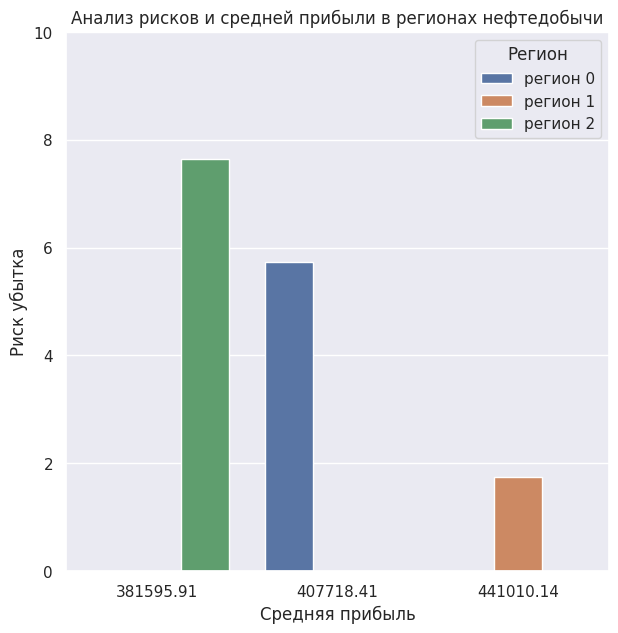

In [17]:
# Добавим графическое отображение результатов
plt.figure(figsize=(7, 7))
plt.ylim(0, 10)
sns.set(style="darkgrid")
sns.barplot(x='Средняя прибыль', y='Риск убытка', data=profit, hue=profit.index)
plt.title('Анализ рисков и средней прибыли в регионах нефтедобычи')
plt.show()

## Общий вывод по работе <a id='section0.5'></a>

По условиям задания нам необходимо выбрать регион, в котором риск убытков не выше 2,5%.

По этому критерию нам подходит только `регион 1`. В остальных регионах риск убытков значительно выше.

Согласно рассчитанному доверительному интервалу в данном регионе с вероятностью 95% можно получить от 36 до 835 млн. рублей прибыли. А показатель средней прибыли равняется 441 млн. Что даже без учета риска убытков выше, чем в других регионах.